In [1]:
import os
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
from models.edsr import edsr
import matplotlib as plt
import seaborn as sns
import math

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-09-09 16:06:16.324543: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 16:06:16.363909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 16:06:16.363945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 16:06:16.363968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 16:06:16.371017: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 16:06:16.371730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Utility functions (preprocessing)

In [2]:
def quantile_clipping(data, percentage, mode="max"):
    quantile_val = np.quantile(data, percentage)
    if mode == "max":
        data = data.clip(max=quantile_val)
    if mode == "min":
        data = data.clip(min=quantile_val)
    return data

def exp_root_norm(data, exp=2):
    return data ** (1 / exp)

def minmax_scale(images):
    # Assuming images is a 4D array with shape (N, 32, 32)
    min_val = np.min(images)
    max_val = np.max(images)
    
    scaled_images = (images - min_val) / (max_val - min_val)
    
    return scaled_images

def preprocess(images):
    images = quantile_clipping(images, 0.95, mode="max")
    images = exp_root_norm(images, exp=2)
    images = minmax_scale(images)
    return images


# def pad_to_nearest_square(matrix, num_clients):
#     """
#     Pad the matrix to the nearest size that's perfectly divisible by sqrt(num_clients).
#     """
#     orig_height, orig_width = matrix.shape[1:3]
#     sqrt_clients = int(math.sqrt(num_clients))
    
#     target_size = math.ceil(max(orig_height, orig_width) / sqrt_clients) * sqrt_clients
    
#     padded = np.pad(
#         matrix,
#         ((0, 0), (0, target_size - orig_height), (0, target_size - orig_width), (0, 0)),
#         mode='constant'
#     )
    
#     return padded, (orig_height, orig_width)


## Utility functions (create federated data)

In [3]:
def extract_node_locations():
    nodes = [
        "at1.at", "be1.be", "ch1.ch", "cz1.cz", "de1.de", "es1.es", "fr1.fr", "gr1.gr",
        "hr1.hr", "hu1.hu", "ie1.ie", "il1.il", "it1.it", "lu1.lu", "nl1.nl", "ny1.ny",
        "pl1.pl", "pt1.pt", "se1.se", "si1.si", "sk1.sk", "uk1.uk"
    ]
    locations = [
        (16.3729, 48.2091), (4.3518, 50.8469), (6.1399, 46.2038), (14.4423, 50.0785),
        (8.6842, 50.1122), (-3.7033, 40.4167), (2.351, 48.8566), (23.5808, 37.9778),
        (15.9644, 45.8071), (19.0936, 47.4976), (-6.2573, 53.3416), (34.8097, 32.0714),
        (9.19, 45.4642), (6.1296, 49.6112), (4.9407, 52.3236), (-73.94384, 40.6698),
        (16.8874, 52.3963), (-9.1363, 38.7073), (17.8742, 59.3617), (14.5148, 46.0574),
        (17.1297, 48.1531), (-0.1264, 51.5086)
    ]
    return np.array(nodes), np.array(locations)

def cluster_nodes(locations, n_clusters):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(locations)
    return clusters

def pad_fine_grained_matrix(fine_grained, num_clients):
    num_samples, height, width, channels = fine_grained.shape
    sqrt_clients = int(np.ceil(np.sqrt(num_clients)))
    
    # Calculate required padding
    pad_height = math.ceil(height / sqrt_clients) * sqrt_clients - height
    pad_width = math.ceil(width / sqrt_clients) * sqrt_clients - width
    
    if pad_height == 0 and pad_width == 0:
        return fine_grained
    
    padded_fine_grained = np.pad(fine_grained, 
                                 ((0, 0), (0, pad_height), (0, pad_width), (0, 0)), 
                                 mode='constant')
    
    # Fill padding with average values
    if pad_height > 0:
        padded_fine_grained[:, -pad_height:, :, :] = np.mean(fine_grained[:, -1:, :, :], axis=(1, 2), keepdims=True)
    if pad_width > 0:
        padded_fine_grained[:, :, -pad_width:, :] = np.mean(fine_grained[:, :, -1:, :], axis=(1, 2), keepdims=True)
    
    return padded_fine_grained

def create_client_data(fine_matrices, num_clients, c_scale_factor, nodes, locations):
    print(f"Splitting data across {num_clients} clients...")
    num_samples, height, width, channels = fine_matrices.shape
    
    # Calculate the size of each square sub-matrix
    sub_size = int(np.floor(np.sqrt(min(height, width) ** 2 / num_clients)))

    node_grid_size = int(np.ceil(np.sqrt(len(nodes))))
    
    # Adjust sub_size to be divisible by c_scale_factor
    sub_size = (sub_size // c_scale_factor) * c_scale_factor
    
    # Ensure sub_size is at least c_scale_factor
    sub_size = max(sub_size, c_scale_factor)
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_clients)))
    
    # Calculate new dimensions to fit exactly num_clients square sub-matrices
    new_side = grid_size * sub_size
    
    # Resize the fine matrices
    resized_fine_matrices = np.zeros((num_samples, new_side, new_side, channels))
    resized_fine_matrices[:, :min(height, new_side), :min(width, new_side), :] = fine_matrices[:, :min(height, new_side), :min(width, new_side), :]
    
    # Create node_mapping
    node_mapping = {node: idx for idx, node in enumerate(nodes)}
    
    client_data = []
    for client in range(num_clients):
        row = client // grid_size
        col = client % grid_size
        
        start_i = row * sub_size
        start_j = col * sub_size
        
        # Extract partial ground truth for this client
        client_fine = resized_fine_matrices[:, start_i:start_i+sub_size, start_j:start_j+sub_size, :]
        
        # Extract nodes and locations for this client
        client_nodes = []
        client_locations = []
        for i in range(sub_size):
            for j in range(sub_size):
                node_row = (start_i + i) % node_grid_size
                node_col = (start_j + j) % node_grid_size
                idx = node_row * node_grid_size + node_col                
                if idx < len(nodes):
                    client_nodes.append(nodes[idx])
                    client_locations.append(locations[idx])
        
        if not client_locations:
            print("323")
        client_nodes = np.array(client_nodes)
        client_locations = np.array(client_locations)
        
        # Create low-resolution version using clustering, only with real nodes
        client_coarse = create_coarse_grained(client_fine, client_locations, c_scale_factor)
        
        client_data.append((client_coarse, client_fine))
    
    return client_data

def create_coarse_grained_matrix(fine_grained_matrix, clusters):
    n_clusters = len(np.unique(clusters))
    coarse_grained_matrix = np.zeros((n_clusters, n_clusters))
    
    # Ensure fine_grained_matrix and clusters have the same size
    valid_size = min(fine_grained_matrix.shape[0], len(clusters))
    fine_grained_matrix = fine_grained_matrix[:valid_size, :valid_size]
    clusters = clusters[:valid_size]
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            mask_i = clusters == i
            mask_j = clusters == j
            coarse_grained_matrix[i, j] = np.sum(fine_grained_matrix[np.ix_(mask_i, mask_j)])
    
    return coarse_grained_matrix

def create_coarse_grained(fine_matrix, locations, scale_factor):
    num_samples, height, width, channels = fine_matrix.shape
    
    # Calculate number of clusters
    # n_clusters = math.ceil(height / scale_factor) * math.ceil(width / scale_factor)
    n_clusters = height // scale_factor
    if height % scale_factor != 0:
        raise ValueError("Height must be divisible by scale factor")
    
    # Perform clustering
    clusters = cluster_nodes(locations, n_clusters)
    
    # Initialize coarse-grained matrix
    # coarse_height = math.floor(height / scale_factor)
    # coarse_width = math.floor(width / scale_factor)
    
    # Create coarse-grained matrix
    coarse_matrix = np.array([create_coarse_grained_matrix(matrix, clusters) for matrix in fine_matrix]).astype(np.float32)
    coarse_matrix = coarse_matrix.reshape(-1, n_clusters, n_clusters, channels)
    
    return coarse_matrix


### Saving functions

In [4]:
import pickle

def save_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

## PARAMETERS

In [7]:
dataset = 'geant'
if dataset == 'geant':
    scale_factor = 2
    num_clients = 7
    c_scale_factor = scale_factor  # This determines the downsampling factor for creating coarse-grained matrices for each client
    path_to_data = 'CNSM/data'
    original_size = 22
    ground_truth = f'{dataset}_original_{original_size}.npy'
    # overlap_percentage = 5
    NUM_ROUNDS = 20
elif dataset == 'germany':
    scale_factor = 2
    num_clients = 2
    c_scale_factor = 2  # This determines the downsampling factor for creating coarse-grained matrices for each client
    path_to_data = 'CNSM/data'
    ground_truth = 'germany_original_161.npy'
    original_size = 161
    coarse_size = original_size // scale_factor
    train_file = f'germany_coarse_{coarse_size}_x{scale_factor}.npy'
    NUM_ROUNDS = 20

## Training

### Split data across clients

In [13]:
# Load and preprocess your data
train_file = f'{dataset}_coarse_{original_size//scale_factor}_x{scale_factor}.npy'
train_set = np.load(os.path.join(path_to_data, train_file)).astype(np.float32)
train_ground_truth = np.load(os.path.join(path_to_data, ground_truth)).astype(np.float32)
# node_to_index = np.load(os.path.join(path_to_data, 'node_to_index.npy'), allow_pickle=True).item()

train_set = train_set.reshape((-1, 11, 11, 1))
train_ground_truth = train_ground_truth.reshape((-1, 22, 22, 1))

print(f"Train set shape: {train_set.shape}", "Ground truth shape:", train_ground_truth.shape)

train_set = preprocess(train_set)
train_ground_truth = preprocess(train_ground_truth)

# Extract node locations and cluster them
nodes, locations = extract_node_locations() # for GAENT dataset

# Create client data
data_filename = f"client_data_{num_clients}_x{scale_factor}_overlap.pkl"
if not os.path.exists(f'CNSM/fed_data/{data_filename}'):
    client_data = create_client_data(train_ground_truth, num_clients, c_scale_factor, nodes, locations)
    save_pickle(client_data, f'CNSM/fed_data/{data_filename}')
else:
    print("Loading data")
    client_data = load_pickle(f'CNSM/fed_data/{data_filename}')
# Print the shape of the client data
for i, client in enumerate(client_data):
    print(f"Client {i} LR:", client[0].shape, "Client {i} HR", client[1].shape)

ValueError: cannot reshape array of size 2873600 into shape (11,11,1)

### Federated Model

In [16]:
import time

# Define the TFF model
def model_fn():
    keras_model = edsr(input_depth=1, scale=2, num_filters=64, num_res_blocks=8)
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=(
            tf.TensorSpec(shape=(None, coarse_matrix_size, coarse_matrix_size, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, fine_matrix_size, fine_matrix_size, 1), dtype=tf.float32)
        ),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

def create_tf_dataset_for_client(client_data):
    def batch_format_fn(x, y):
        return (x, y)
    dataset = tf.data.Dataset.from_tensor_slices(client_data)
    dataset = dataset.shuffle(buffer_size=len(client_data[0]))
    dataset = dataset.batch(32)
    dataset = dataset.map(batch_format_fn)
    return dataset

# Shapes of the client data
coarse_matrix_size = client_data[0][0].shape[1]
fine_matrix_size = client_data[0][1].shape[1]
data_filename = f'CNSM/fed_data/client_data_{num_clients}_x{scale_factor}.pkl'
if os.path.exists(data_filename):
    client_data = load_pickle(data_filename)

# Convert all clients data to float 32
client_data = [(x.astype(np.float32), y.astype(np.float32)) for x, y in client_data]
federated_train_data = [create_tf_dataset_for_client(cd) for cd in client_data]

# Create the federated learning process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=1e-3),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=1e-3)
)

# Initialize the server state
state = iterative_process.initialize()

 #Perform federated training
NUM_ROUNDS = 20
start = time.time()
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}')
    print(metrics)

end = time.time()
print(f"Training time: {end - start}")
# Save training time
save_pickle(end - start, f'CNSM/fed_data/{dataset}_fed_training_time_{num_clients}_x{scale_factor}_rounds_{NUM_ROUNDS}.pkl')
# Save the federated weights
fed_weights = state[0].trainable
# Save weights
save_pickle(fed_weights, f'CNSM/fed_data/geant_fed_weights_{num_clients}_x{scale_factor}_rounds_{NUM_ROUNDS}.pkl')

2024-07-15 23:13:37.872728: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-15 23:13:37.872891: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-15 23:13:37.999738: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-15 23:13:37.999819: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-15 23:13:41.604887: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-15 23:13:41.605034: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-15 23:13:42.190790: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-15 23:13:42.190910: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Round 0
OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 0.019651784), ('loss', 0.019651778), ('num_examples', 91680), ('num_batches', 2872)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 1
OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 0.015705192), ('loss', 0.015705194), ('num_examples', 91680), ('num_batches', 2872)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2
OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 0.014075226), ('loss', 0.014075226), ('num_examples', 91680), ('num_batches', 2872)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite

## Evaluation

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_set = np.load(os.path.join(path_to_data, train_file)).astype(np.float32)
train_ground_truth = np.load(os.path.join(path_to_data, ground_truth)).astype(np.float32)

# node_to_index = np.load(os.path.join(path_to_data, 'node_to_index.npy'), allow_pickle=True).item()

train_set = train_set.reshape((-1, 11, 11, 1))
train_ground_truth = train_ground_truth.reshape((-1, 22, 22, 1))
print(f"Train set shape: {train_set.shape}", "Ground truth shape:", train_ground_truth.shape)

train_set = preprocess(train_set)
train_ground_truth = preprocess(train_ground_truth)

# Load the federated weights
fed_weights = load_pickle(f'CNSM/fed_data/geant_fed_weights_{num_clients}_x{scale_factor}_rounds_{NUM_ROUNDS}.pkl')

# Create a new model and load the weights
model = edsr(input_depth=1, scale=2, num_filters=64, num_res_blocks=8)
model.set_weights(fed_weights)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())

# Split the data into train and test sets
train_size = int(0.8 * len(train_set))
x_train, x_test = train_set[:train_size], train_set[train_size:]
y_train, y_test = train_ground_truth[:train_size], train_ground_truth[train_size:]

# Flatten the arrays to 1D for easier calculation
test_predictions = model.predict(x_test)
y_true = y_test.flatten()
y_pred = test_predictions.flatten()

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Optional: Calculate R-squared (coefficient of determination)
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R-squared: {r2:.4f}")

Train set shape: (11460, 11, 11, 1) Ground truth shape: (11460, 22, 22, 1)
72/72 [==============================] - 2s 20ms/step
Mean Squared Error (MSE): 0.0817
Root Mean Squared Error (RMSE): 0.2859
Mean Absolute Error (MAE): 0.1717
R-squared: -0.0898


/tmp/ipykernel_48479/1429927238.py:43: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [18]:
# Let's save the performance in a csv file
import csv
import os

filename = f'CNSM/fed_data/geant_fed_results_{num_clients}_x{scale_factor}_rounds_{NUM_ROUNDS}.csv'
if not os.path.exists(filename):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["MSE", "RMSE", "MAE", "MAPE", "R2"])
        writer.writerow([mse, rmse, mae, mape, r2])

31/72 [===========>..................] - ETA: 0s

72/72 [==============================] - 1s 20ms/step


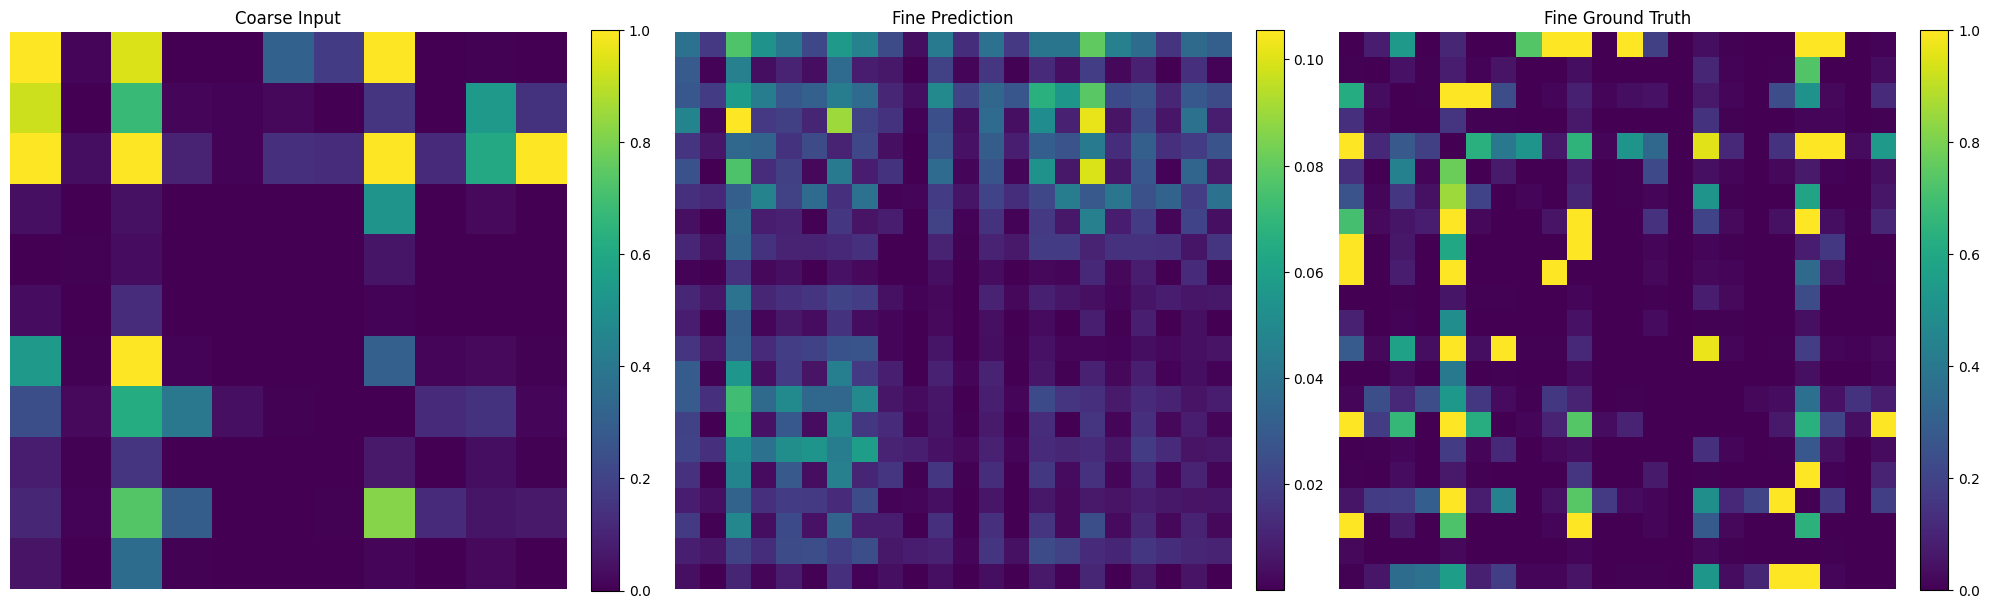

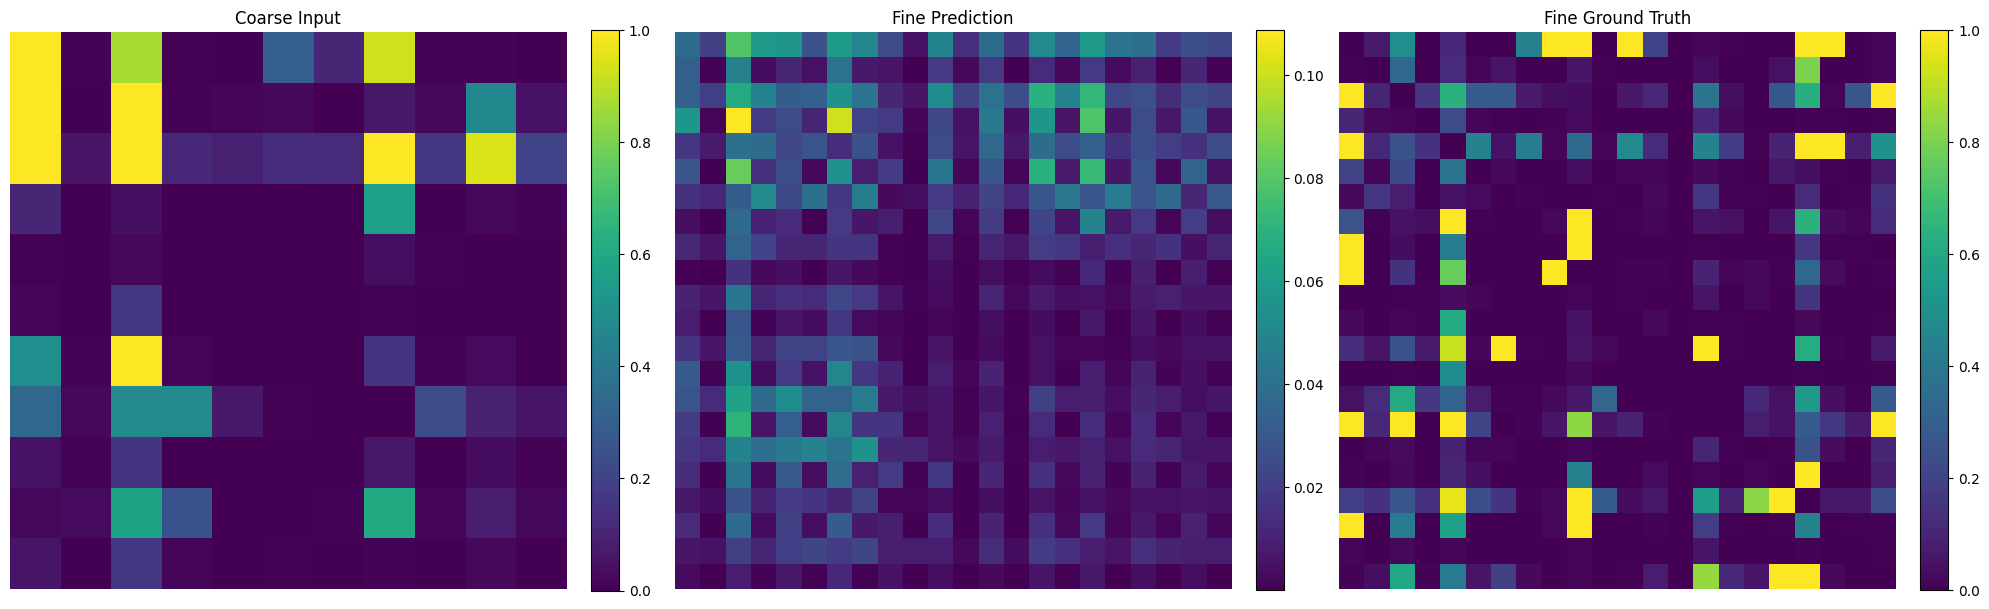

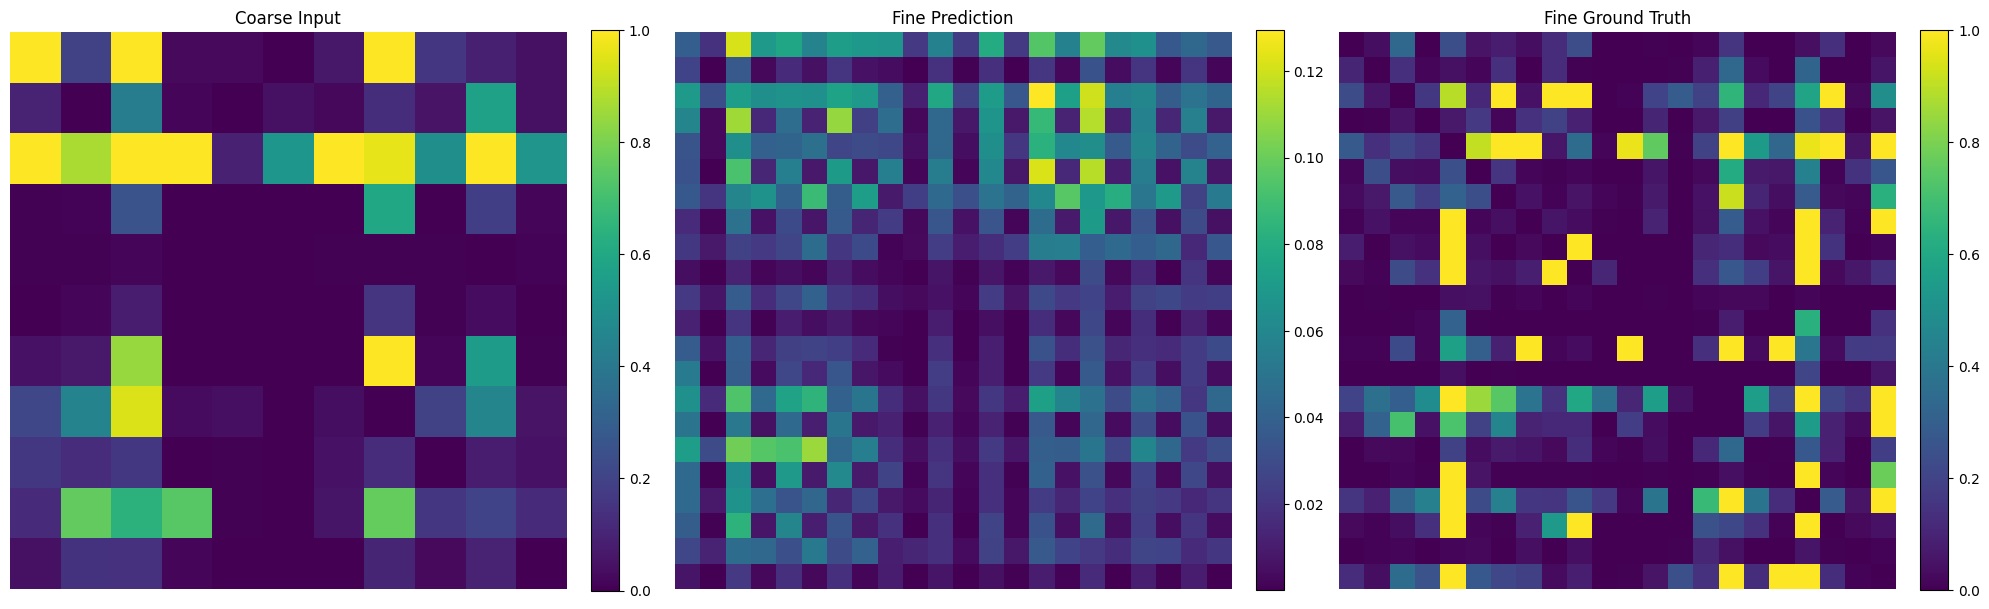

In [19]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def reverse_preprocess(images, original_min, original_max, exp=2):
    # Reverse min-max scaling
    images = images * (original_max - original_min) + original_min
    
    # Reverse exponential root normalization
    images = images ** exp
    
    # Note: We can't reverse the quantile clipping
    return images


def visualize_heatmaps(coarse_input, fine_prediction, fine_ground_truth, index=0):
    """
    Visualize heatmaps for coarse input, fine prediction, and fine ground truth.
    
    :param coarse_input: Coarse-grained input data (shape: [batch, 11, 11, 1])
    :param fine_prediction: Fine-grained prediction (shape: [batch, 22, 22, 1])
    :param fine_ground_truth: Fine-grained ground truth (shape: [batch, 22, 22, 1])
    :param index: Index of the sample to visualize
    """
    # Get original min and max values (you need to store these during preprocessing)
    original_min = np.min(train_ground_truth)
    original_max = np.max(train_ground_truth)

    # Reverse preprocessing
    coarse_input_original = reverse_preprocess(coarse_input, original_min, original_max)
    fine_prediction_original = reverse_preprocess(fine_prediction, original_min, original_max)
    fine_ground_truth_original = reverse_preprocess(fine_ground_truth, original_min, original_max)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Coarse Input
    im1 = ax1.imshow(coarse_input_original[index, :, :, 0], cmap='viridis')
    ax1.set_title('Coarse Input')
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Fine Prediction
    im2 = ax2.imshow(fine_prediction_original[index, :, :, 0], cmap='viridis')
    ax2.set_title('Fine Prediction')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Fine Ground Truth
    im3 = ax3.imshow(fine_ground_truth_original[index, :, :, 0], cmap='viridis')
    ax3.set_title('Fine Ground Truth')
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Visualize a random sample
random_index = np.random.randint(0, len(x_test))
visualize_heatmaps(x_test, test_predictions, y_test, index=random_index)

# Optionally, you can visualize multiple samples in a loop
num_samples_to_visualize = 2
for i in range(num_samples_to_visualize):
    random_index = np.random.randint(0, len(x_test))
    visualize_heatmaps(x_test, test_predictions, y_test, index=random_index)

Visualizing data for Client 1
359/359 [==============================] - 3s 8ms/step


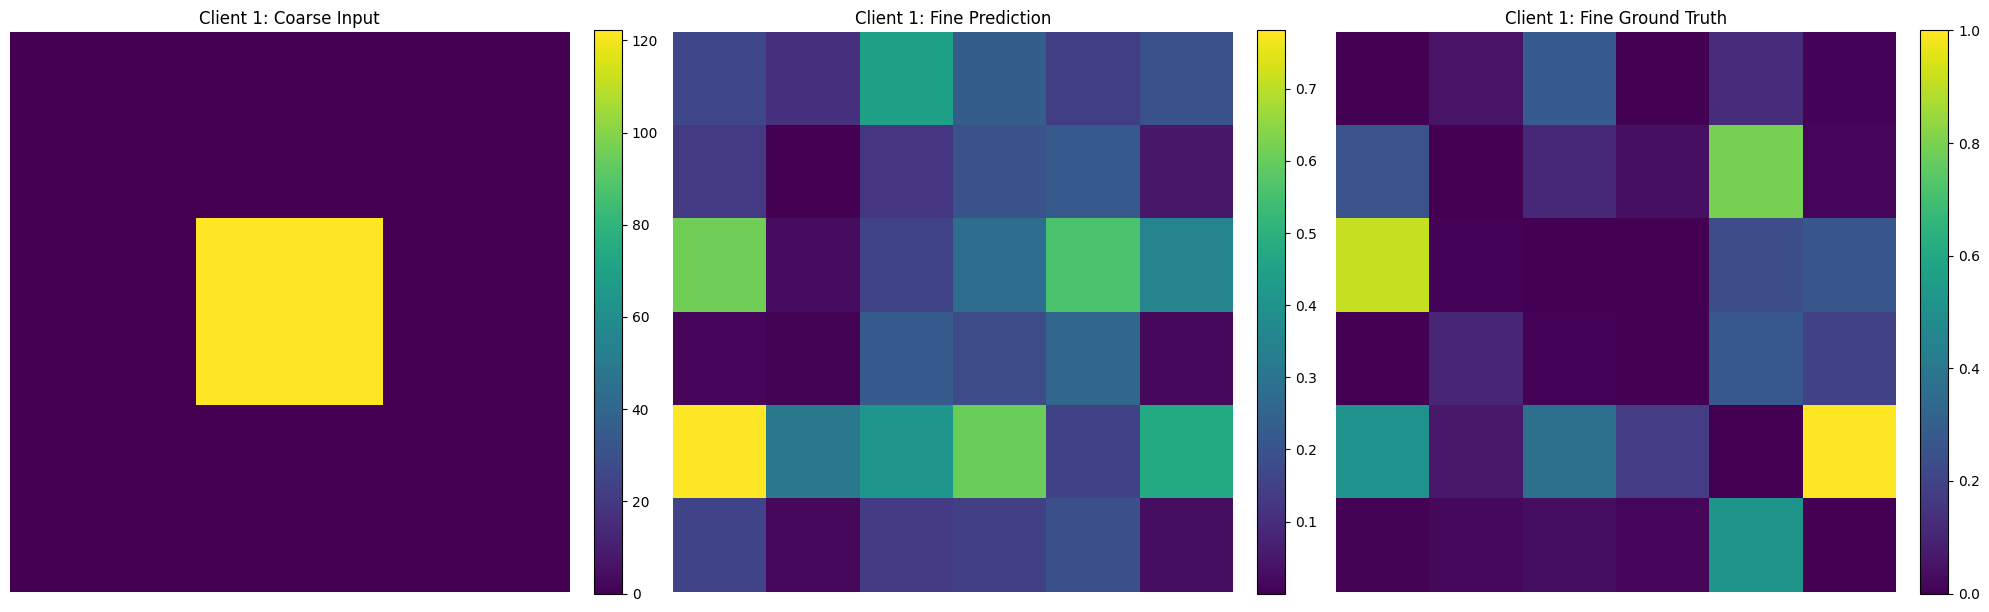

Visualizing data for Client 2
359/359 [==============================] - 3s 8ms/step


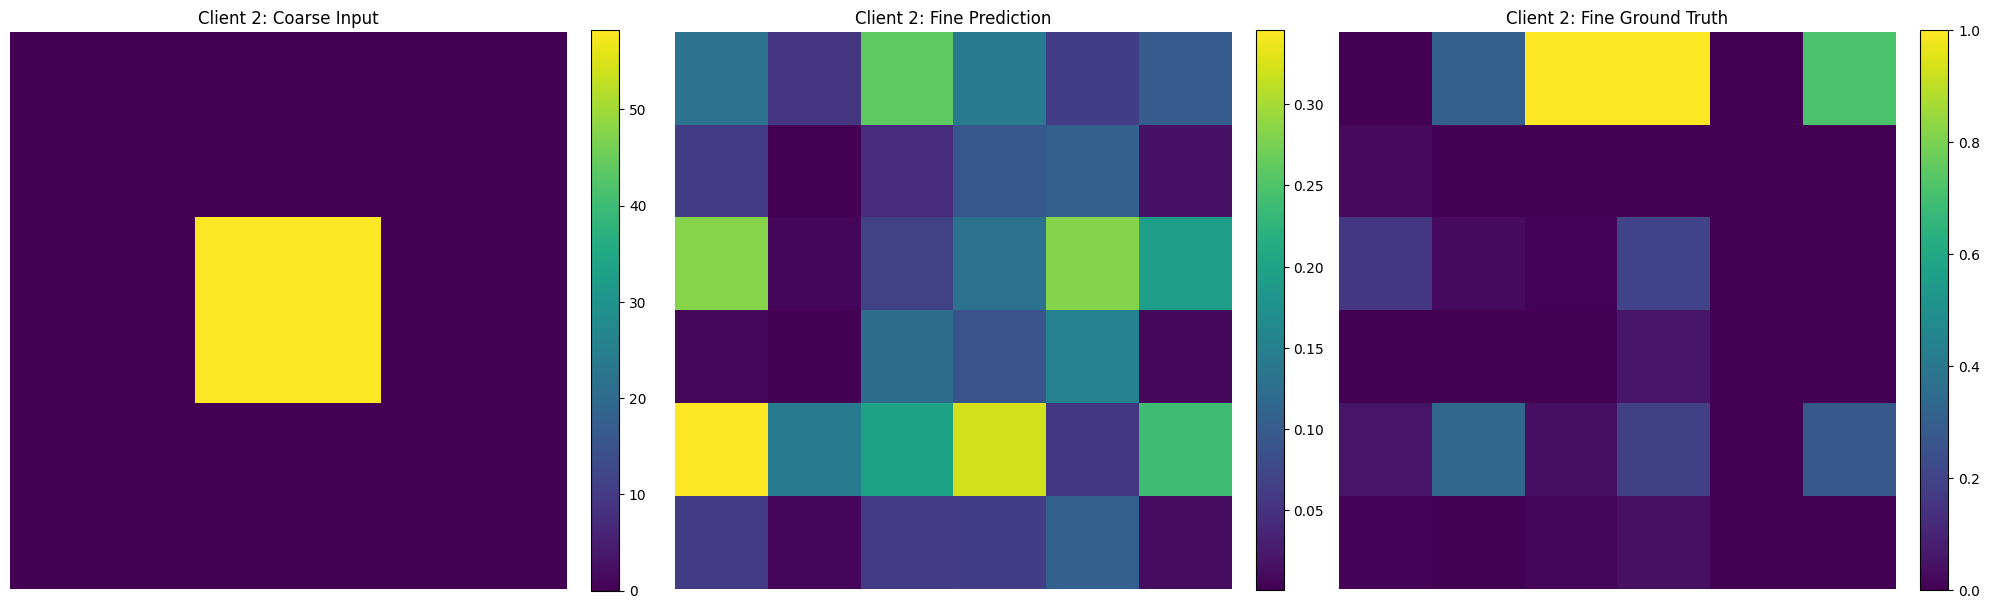

Visualizing data for Client 3
359/359 [==============================] - 3s 8ms/step


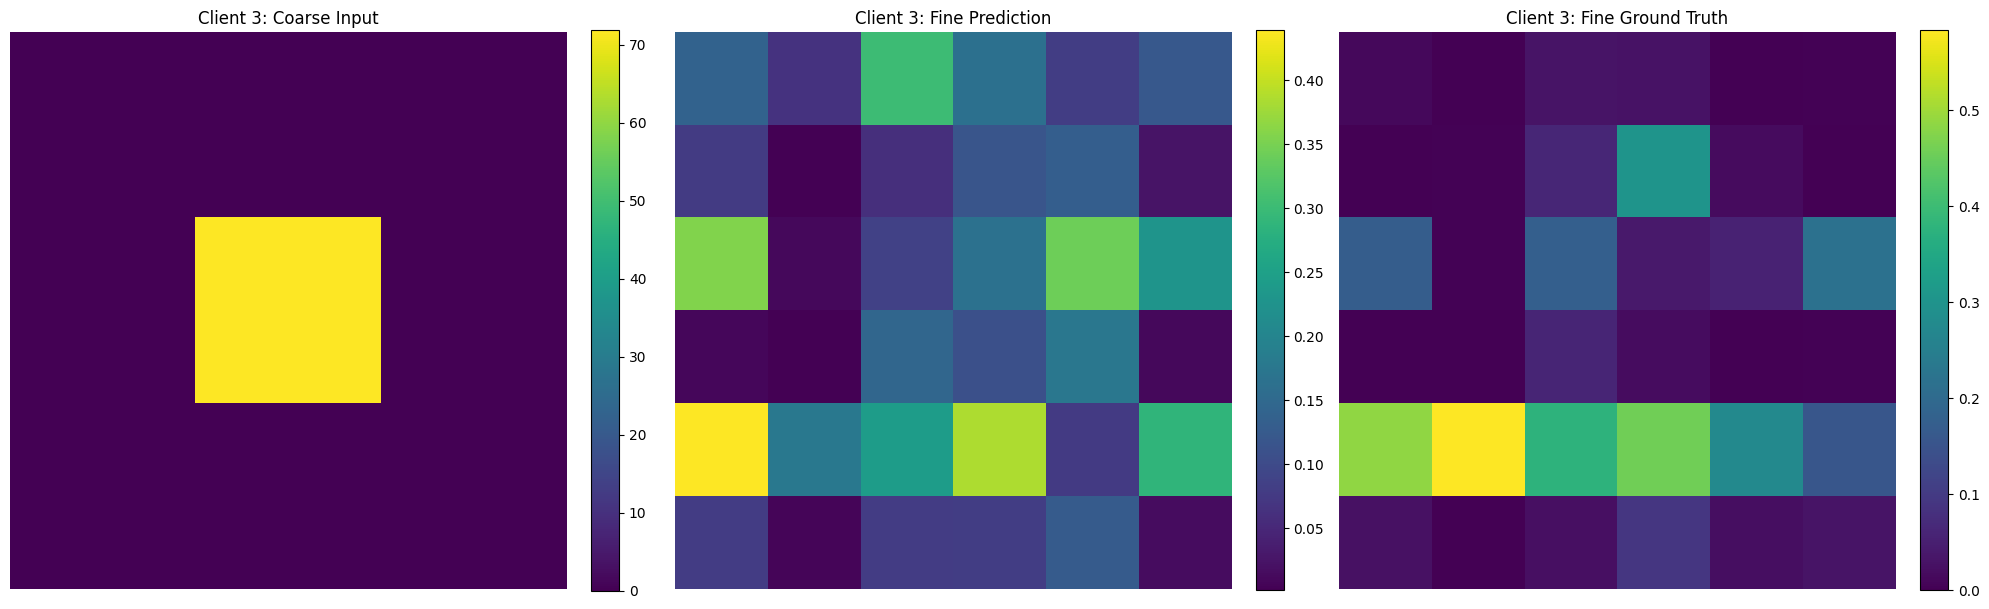

Visualizing data for Client 4
359/359 [==============================] - 3s 8ms/step


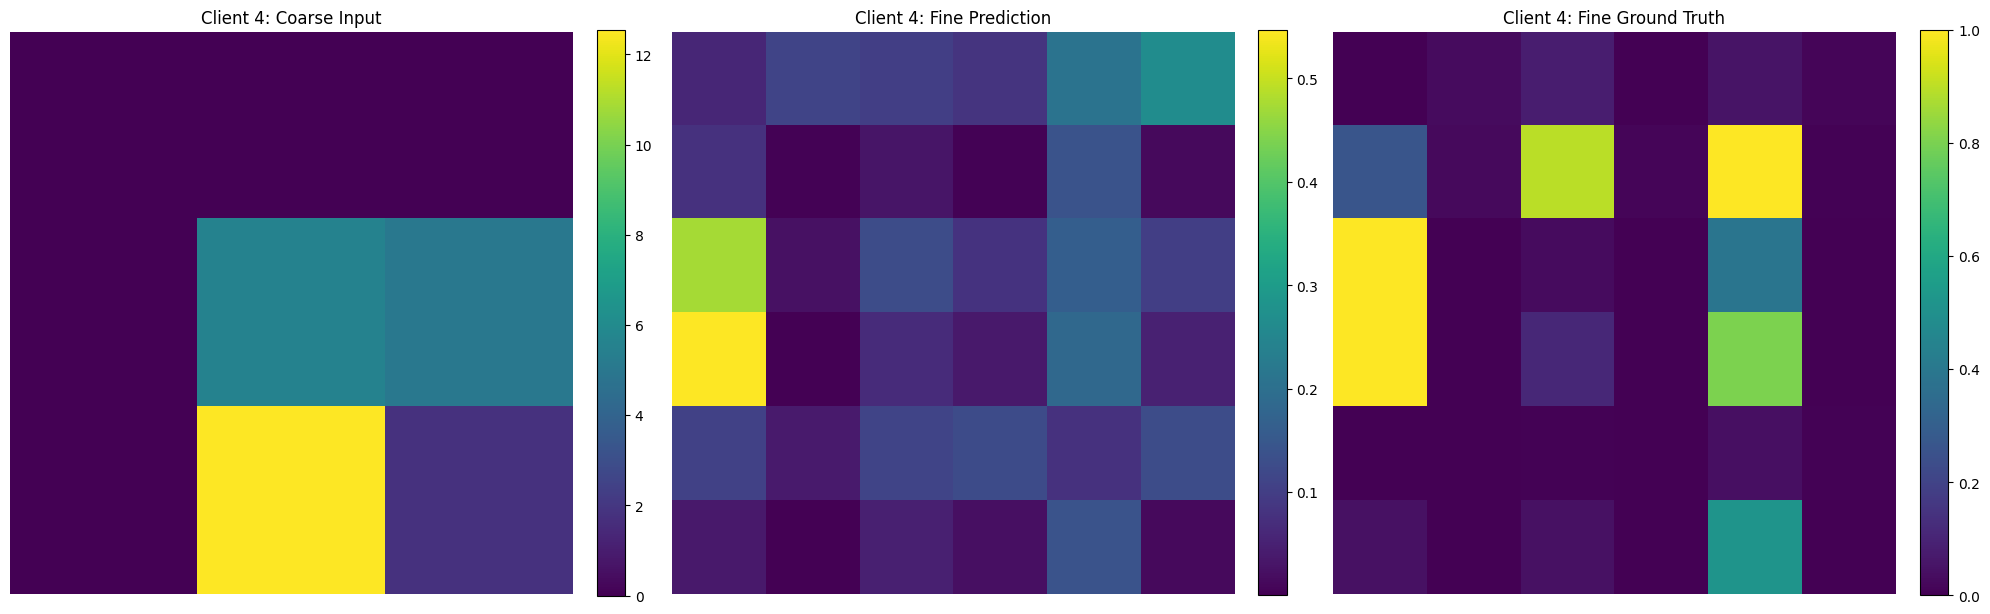

Visualizing data for Client 5
359/359 [==============================] - 3s 8ms/step


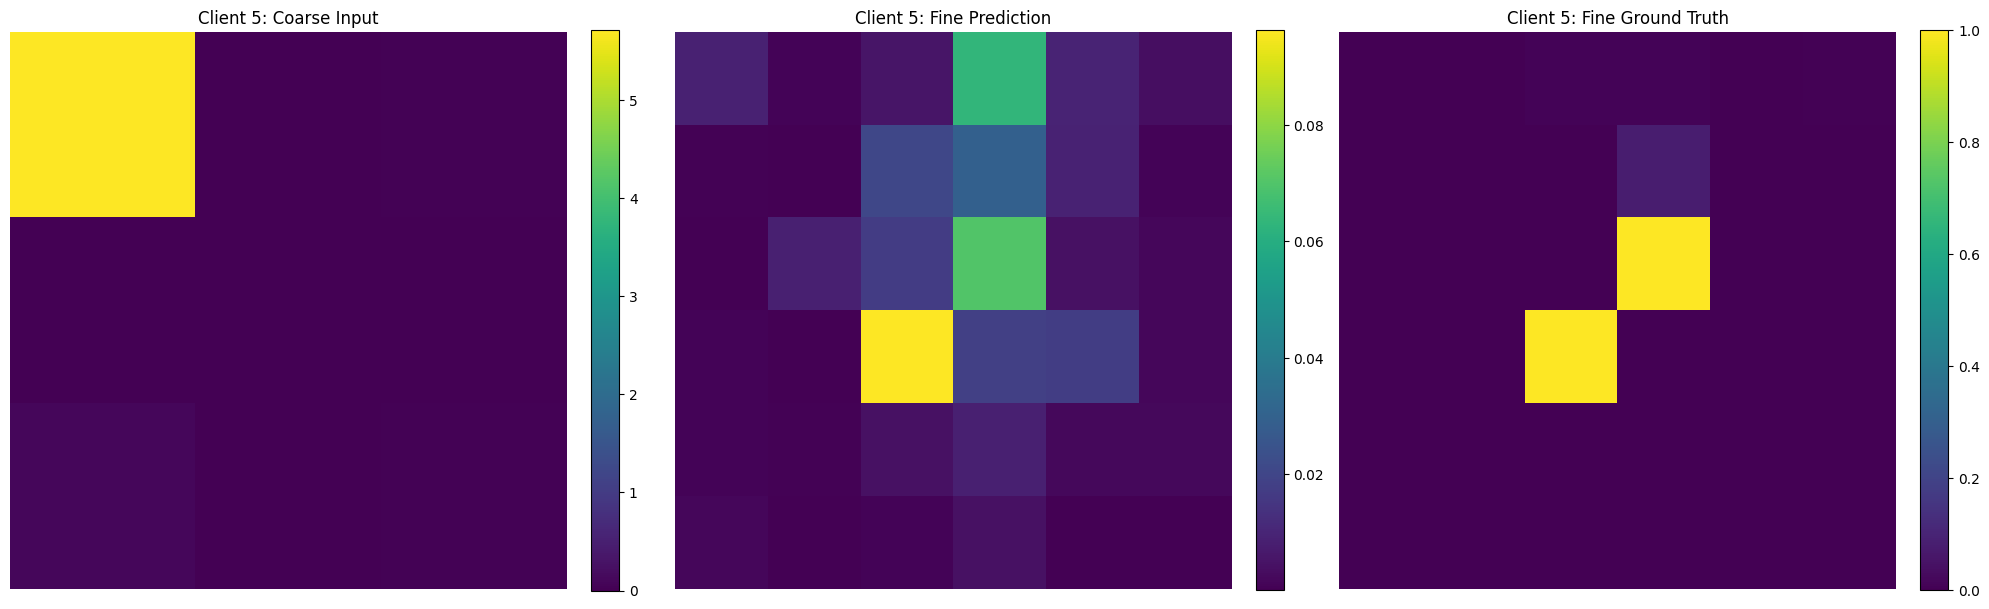

Visualizing data for Client 6
359/359 [==============================] - 3s 8ms/step


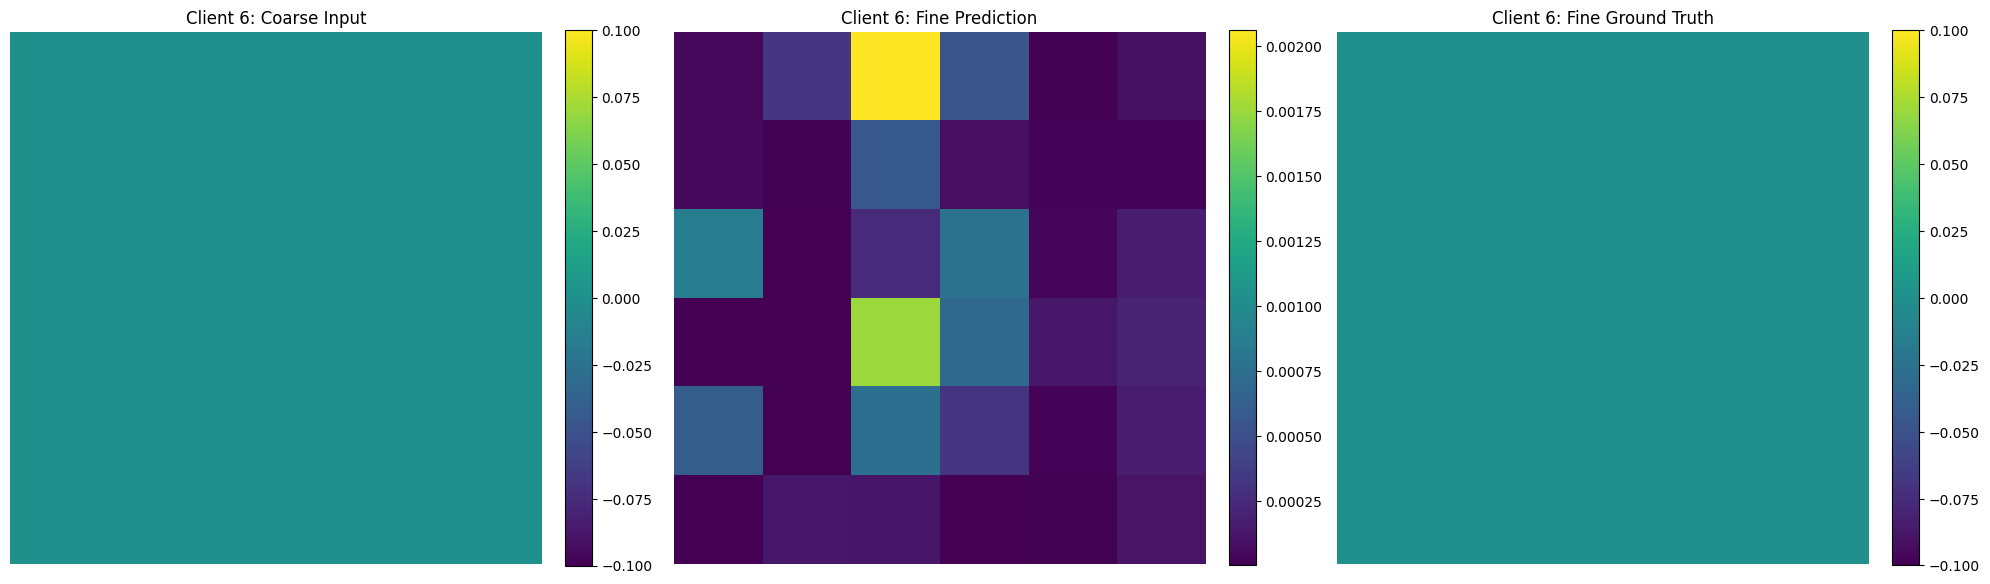

Visualizing data for Client 7
359/359 [==============================] - 3s 8ms/step


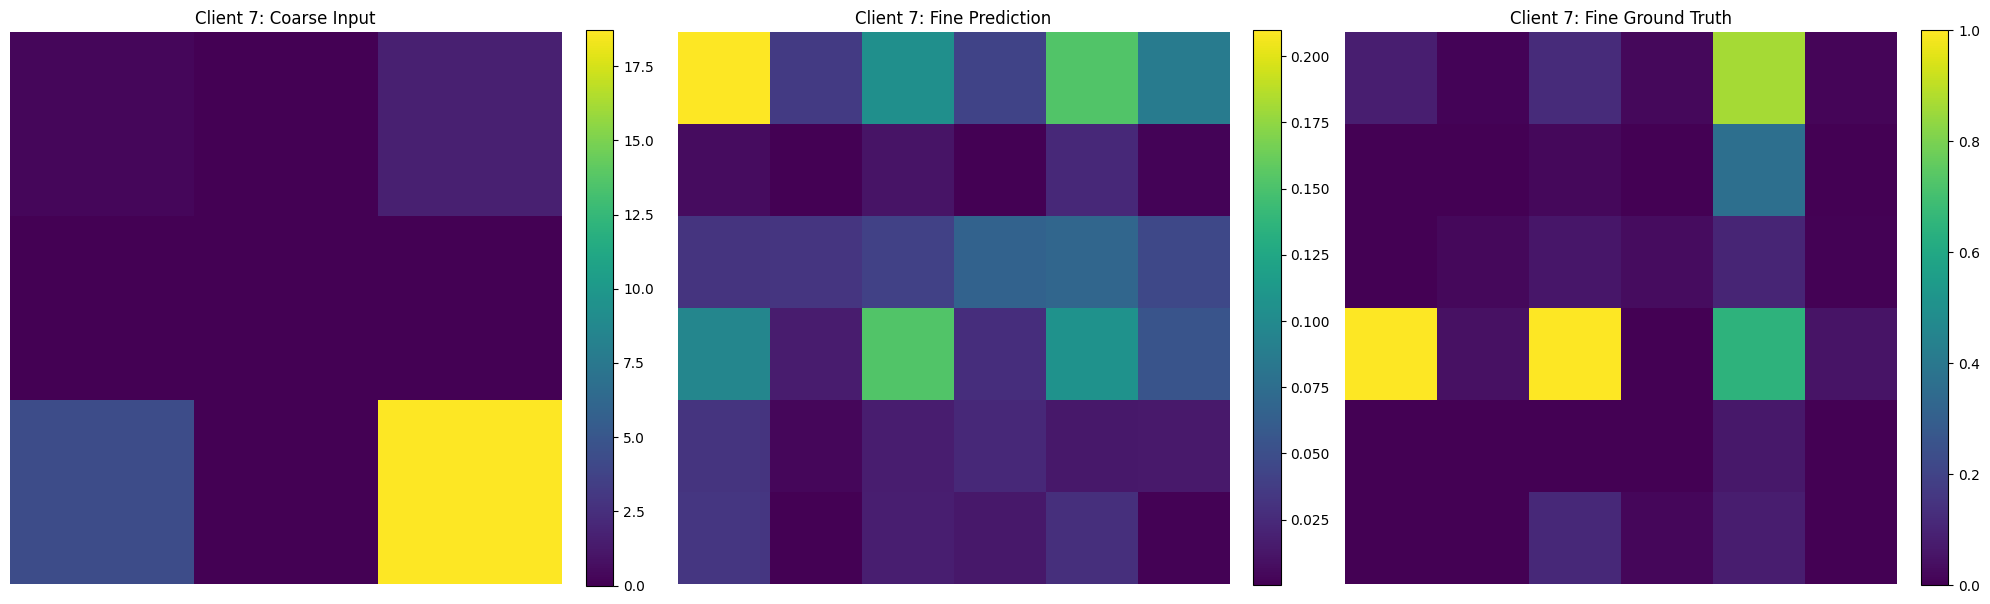

Visualizing data for Client 8
359/359 [==============================] - 3s 8ms/step


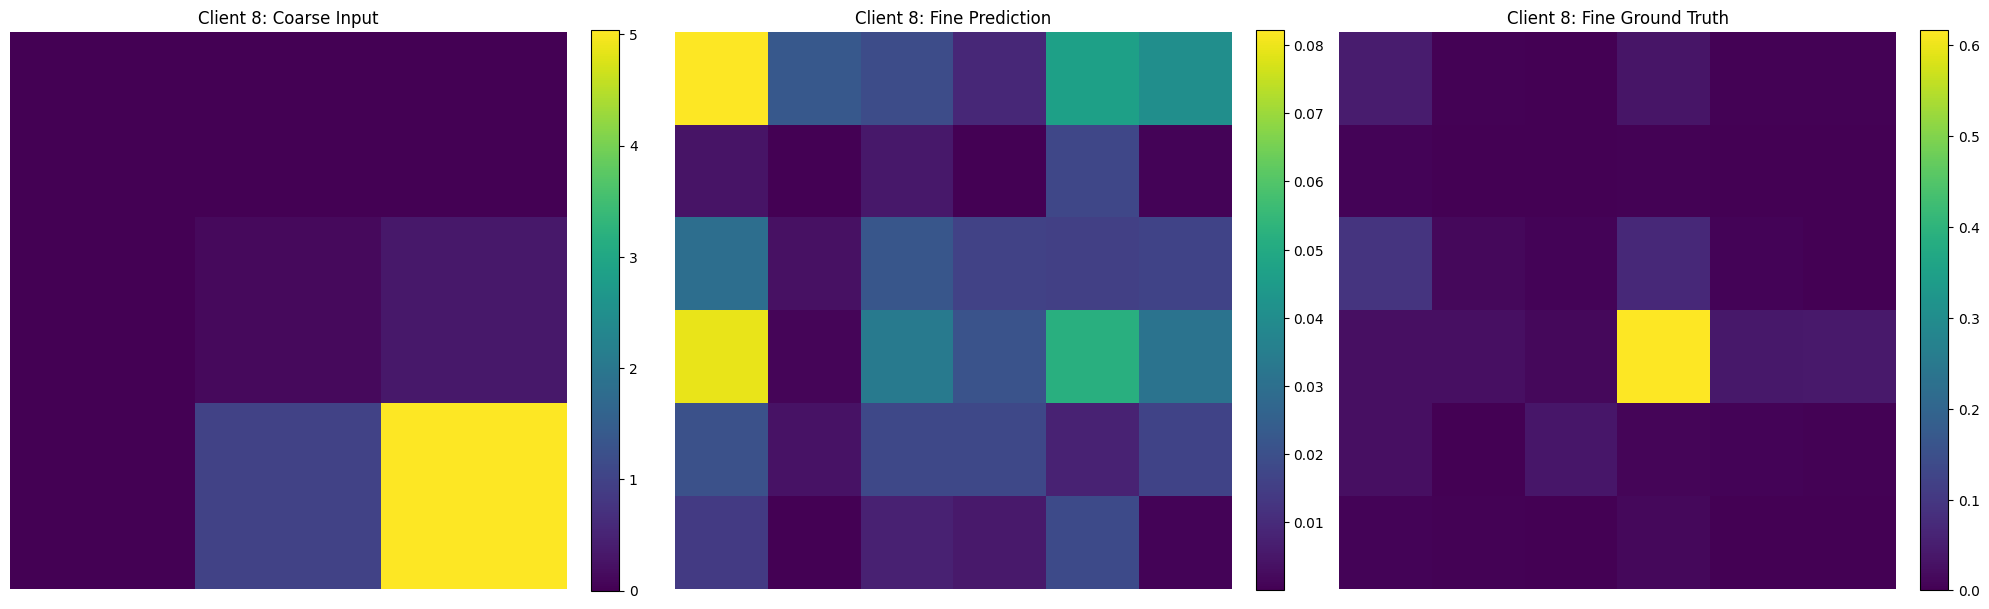

In [20]:
def visualize_client_data(client_data, model, num_samples=3):
    """
    Visualize client data: coarse-grained input, fine-grained prediction, and ground truth.
    
    :param client_data: List of tuples (coarse_input, fine_ground_truth) for each client
    :param model: Trained model to make predictions
    :param num_samples: Number of samples to visualize per client
    """
    num_clients = len(client_data)
    
    for client_idx, (coarse_input, fine_ground_truth) in enumerate(client_data):
        print(f"Visualizing data for Client {client_idx + 1}")
        
        # Get original min and max values
        original_min = np.min(fine_ground_truth)
        original_max = np.max(fine_ground_truth)
        
        # Make predictions
        fine_prediction = model.predict(coarse_input)
        
        # Randomly select samples
        sample_indices = np.random.choice(coarse_input.shape[0], num_samples, replace=False)
        
        for sample_idx in sample_indices:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
            
            # Reverse preprocessing
            coarse_original = reverse_preprocess(coarse_input[sample_idx], original_min, original_max)
            pred_original = reverse_preprocess(fine_prediction[sample_idx], original_min, original_max)
            truth_original = reverse_preprocess(fine_ground_truth[sample_idx], original_min, original_max)
            
            # Coarse Input
            im1 = ax1.imshow(coarse_original[:, :, 0], cmap='viridis')
            ax1.set_title(f'Client {client_idx + 1}: Coarse Input')
            ax1.axis('off')
            plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
            
            # Fine Prediction
            im2 = ax2.imshow(pred_original[:, :, 0], cmap='viridis')
            ax2.set_title(f'Client {client_idx + 1}: Fine Prediction')
            ax2.axis('off')
            plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
            
            # Fine Ground Truth
            im3 = ax3.imshow(truth_original[:, :, 0], cmap='viridis')
            ax3.set_title(f'Client {client_idx + 1}: Fine Ground Truth')
            ax3.axis('off')
            plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.show()


client_data = load_pickle(f'CNSM/fed_data/client_data_{num_clients}_x{scale_factor}.pkl')  # Adjust the path as needed

# Create and load the model
model = edsr(input_depth=1, scale=2, num_filters=64, num_res_blocks=8)
fed_weights = load_pickle(f'CNSM/fed_data/geant_fed_weights_{num_clients}_x{scale_factor}_rounds_{NUM_ROUNDS}.pkl')
model.set_weights(fed_weights)

# Visualize client data
visualize_client_data(client_data, model, num_samples=1)

In [22]:
# load training times from the pickle files
num_clients = 4
NUM_ROUNDS = 20
scale_factor = 2
training_times = []
load_pickle(f'CNSM/fed_data/germany_training_time_{num_clients}_x{scale_factor}_rounds_{NUM_ROUNDS}.pkl')

498.9732503890991